# Female Births
##### *Diego Duarte 22075 -  Paula Barillas 22764*

### Análisis Exploratorio

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("./data/daily-total-female-births.csv", parse_dates=True)

print("\nPrimeras 5 filas:")
print(df.head())

print("\nEstadísticas descriptivas:")
print(df.describe())


Primeras 5 filas:
         Date  Births
0  1959-01-01      35
1  1959-01-02      32
2  1959-01-03      30
3  1959-01-04      31
4  1959-01-05      44

Estadísticas descriptivas:
           Births
count  365.000000
mean    41.980822
std      7.348257
min     23.000000
25%     37.000000
50%     42.000000
75%     46.000000
max     73.000000


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
print(df.head())
print(df.info())

            Births
Date              
1959-01-01      35
1959-01-02      32
1959-01-03      30
1959-01-04      31
1959-01-05      44
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 1959-01-01 to 1959-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Births  365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB
None


Text(0, 0.5, 'Frecuencia')

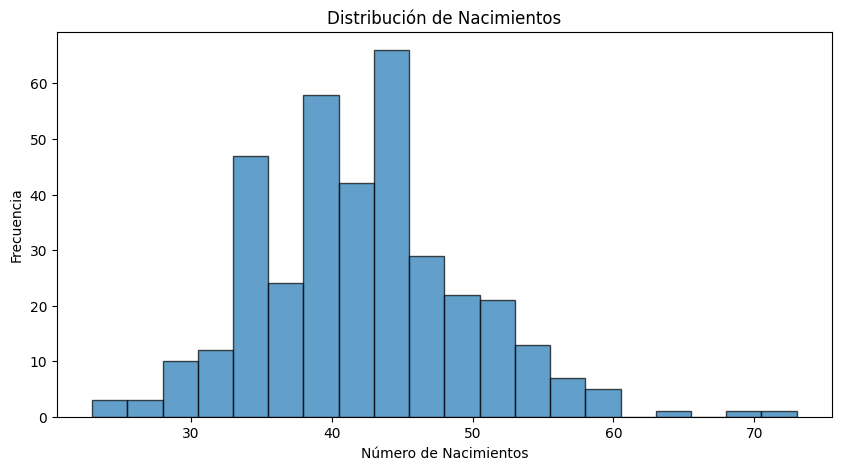

In [4]:
plt.figure(figsize=(10, 5))
plt.hist(df['Births'], bins=20, alpha=0.7, edgecolor='black')
plt.title('Distribución de Nacimientos')
plt.xlabel('Número de Nacimientos')
plt.ylabel('Frecuencia')


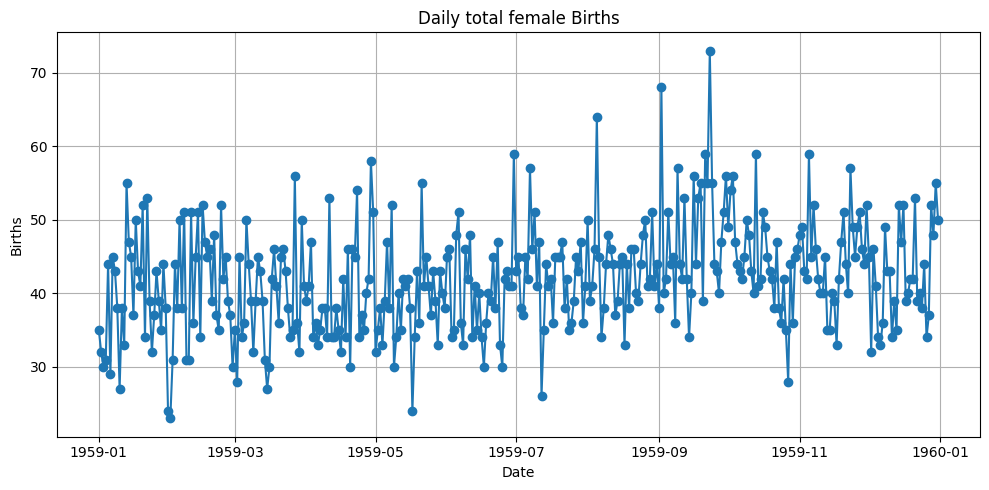

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Births'], marker='o', linestyle='-')
plt.title('Daily total female Births')
plt.xlabel('Date')
plt.ylabel('Births')
plt.grid(True)
plt.tight_layout()
plt.show()

### Promedios Móviles

In [6]:
train_size = int(len(df) * 0.7)
train = df['Births'][:train_size]
test = df['Births'][train_size:]

print(f"Tamaño de entrenamiento: {len(train)} ")
print(f"Tamaño de prueba: {len(test)} ")

results_births = {}

Tamaño de entrenamiento: 255 
Tamaño de prueba: 110 


In [7]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

windows = [3, 7, 14, 30]
for window in windows:
    ma_forecast = train.rolling(window=window).mean()
    last_ma = ma_forecast.iloc[-1]
    ma_pred = [last_ma] * len(test)
    
    rmse = np.sqrt(mean_squared_error(test, ma_pred))
    mae = mean_absolute_error(test, ma_pred)
    
    results_births[f'MA_{window}'] = {'RMSE': rmse, 'MAE': mae, 'predictions': ma_pred}
    print(f"Promedio Móvil {window} días - RMSE: {rmse:.2f}, MAE: {mae:.2f}")


Promedio Móvil 3 días - RMSE: 7.39, MAE: 5.96
Promedio Móvil 7 días - RMSE: 7.30, MAE: 5.84
Promedio Móvil 14 días - RMSE: 7.33, MAE: 5.89
Promedio Móvil 30 días - RMSE: 7.21, MAE: 5.64


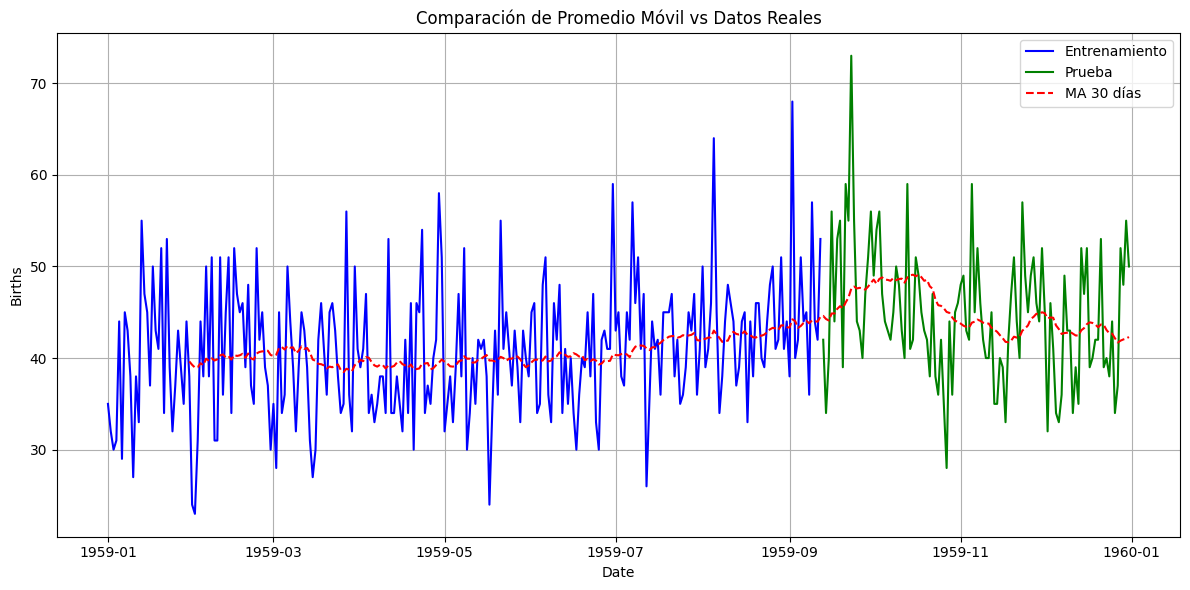

In [8]:
df['MA_30'] = df['Births'].rolling(window=30).mean()
ma_pred = df['MA_30'].loc[test.index]

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Prueba', color='green')
plt.plot(df.index, df['MA_30'], label='MA 30 días', linestyle='--', color='red')

plt.title('Comparación de Promedio Móvil vs Datos Reales')
plt.xlabel('Date')
plt.ylabel('Births')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Alisamiento Exponencial

In [9]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train = train.asfreq('D')
test = test.asfreq('D')

alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
for alpha in alphas:
    model = ExponentialSmoothing(train, trend=None, seasonal=None)
    fitted_model = model.fit(smoothing_level=alpha)
    exp_pred = fitted_model.forecast(steps=len(test))
    
    rmse = np.sqrt(mean_squared_error(test, exp_pred))
    mae = mean_absolute_error(test, exp_pred)
    
    results_births[f'EXP_{alpha}'] = {'RMSE': rmse, 'MAE': mae, 'predictions': exp_pred}
    print(f"Alisamiento Exponencial α={alpha} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")

Alisamiento Exponencial α=0.1 - RMSE: 7.29, MAE: 5.84
Alisamiento Exponencial α=0.3 - RMSE: 7.68, MAE: 6.27
Alisamiento Exponencial α=0.5 - RMSE: 8.19, MAE: 6.76
Alisamiento Exponencial α=0.7 - RMSE: 8.99, MAE: 7.50
Alisamiento Exponencial α=0.9 - RMSE: 10.20, MAE: 8.61


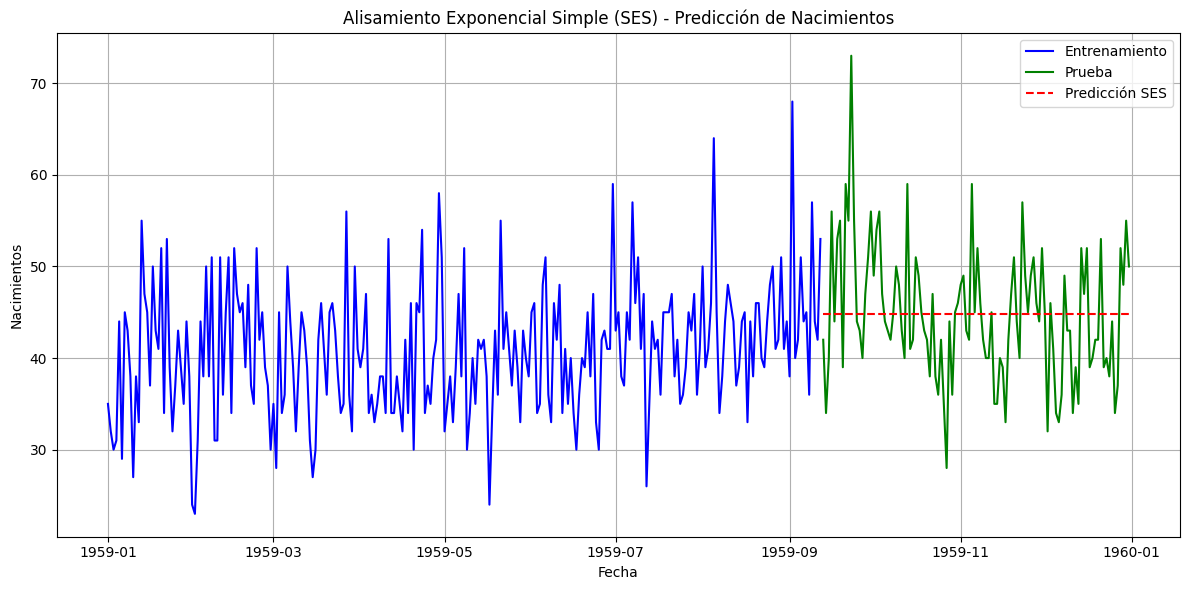

In [10]:
# Alisamiento exponencial simple
modelo = SimpleExpSmoothing(train)
modelo_ajustado = modelo.fit()

prediccion = modelo_ajustado.forecast(len(test))
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Prueba', color='green')
plt.plot(test.index, prediccion, label='Predicción SES', color='red', linestyle='--')

plt.title("Alisamiento Exponencial Simple (SES) - Predicción de Nacimientos")
plt.xlabel("Fecha")
plt.ylabel("Nacimientos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### HOLT-WINTERS

In [11]:
# Holt-Winters sin estacionalidad 
model_holt = ExponentialSmoothing(train, trend='add', seasonal=None)
fitted_holt = model_holt.fit()
holt_pred = fitted_holt.forecast(steps=len(test))

rmse = np.sqrt(mean_squared_error(test, holt_pred))
mae = mean_absolute_error(test, holt_pred)

results_births['HOLT'] = {'RMSE': rmse, 'MAE': mae, 'predictions': holt_pred}
print(f"Holt (tendencia lineal) - RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Holt-Winters con estacionalidad semanal

model_hw = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)
fitted_hw = model_hw.fit()
hw_pred = fitted_hw.forecast(steps=len(test))

rmse = np.sqrt(mean_squared_error(test, hw_pred))
mae = mean_absolute_error(test, hw_pred)

results_births['HOLT_WINTERS'] = {'RMSE': rmse, 'MAE': mae, 'predictions': hw_pred}
print(f"Holt-Winters (estacionalidad semanal) - RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    

Holt (tendencia lineal) - RMSE: 7.39, MAE: 5.72
Holt-Winters (estacionalidad semanal) - RMSE: 7.40, MAE: 5.80


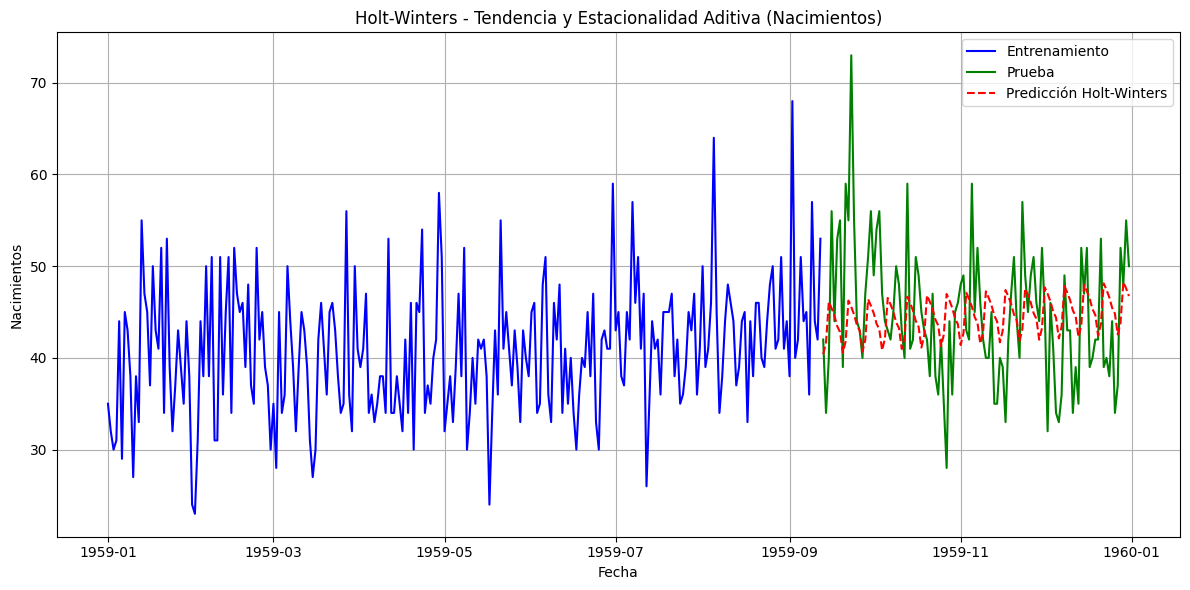

In [12]:
# visualización del modelo Holt-Winters
modelo_hw = ExponentialSmoothing(train,
                                 trend='add',
                                 seasonal='add',
                                 seasonal_periods=7).fit()

pred_hw = modelo_hw.forecast(len(test))

# graficoo
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Prueba', color='green')
plt.plot(test.index, pred_hw, label='Predicción Holt-Winters', color='red', linestyle='--')

plt.title("Holt-Winters - Tendencia y Estacionalidad Aditiva (Nacimientos)")
plt.xlabel("Fecha")
plt.ylabel("Nacimientos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### SARIMA

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_arima = ARIMA(train, order=(1, 1, 1))
fitted_arima = model_arima.fit()
arima_pred = fitted_arima.forecast(steps=len(test))

rmse = np.sqrt(mean_squared_error(test, arima_pred))
mae = mean_absolute_error(test, arima_pred)

results_births['ARIMA'] = {'RMSE': rmse, 'MAE': mae, 'predictions': arima_pred}
print(f"ARIMA(1,1,1) - RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Modelo SARIMA con estacionalidad semanal
model_sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
fitted_sarima = model_sarima.fit()
sarima_pred = fitted_sarima.forecast(steps=len(test))

rmse = np.sqrt(mean_squared_error(test, sarima_pred))
mae = mean_absolute_error(test, sarima_pred)

results_births['SARIMA'] = {'RMSE': rmse, 'MAE': mae, 'predictions': sarima_pred}
print(f"SARIMA(1,1,1)(1,1,1,7) - RMSE: {rmse:.2f}, MAE: {mae:.2f}")

ARIMA(1,1,1) - RMSE: 7.25, MAE: 5.61
SARIMA(1,1,1)(1,1,1,7) - RMSE: 7.77, MAE: 6.20


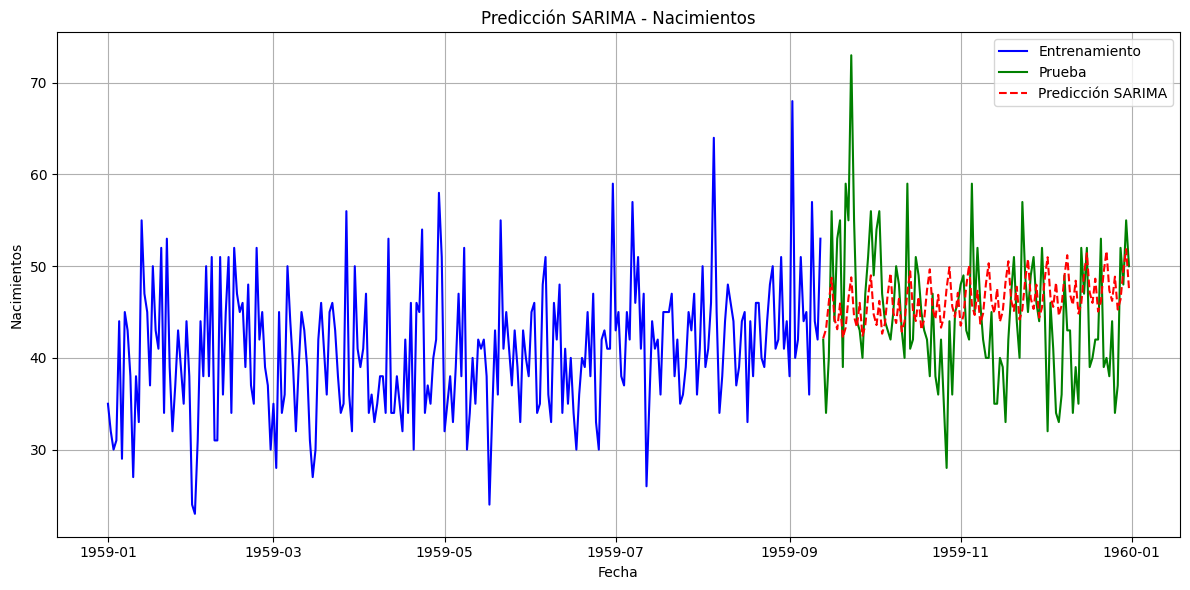

In [14]:
#modelo SARIMA
import statsmodels.api as sm

modelo_sarima = sm.tsa.statespace.SARIMAX(train,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 7)).fit()

pred_sarima = modelo_sarima.predict(start=len(train),
                                    end=len(train)+len(test)-1,
                                    dynamic=False)

# grafico
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Prueba', color='green')
plt.plot(test.index, pred_sarima, label='Predicción SARIMA', color='red', linestyle='--')

plt.title("Predicción SARIMA - Nacimientos")
plt.xlabel("Fecha")
plt.ylabel("Nacimientos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Prophet

C:\Users\rebe1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
20:35:15 - cmdstanpy - INFO - Chain [1] start processing
20:35:15 - cmdstanpy - INFO - Chain [1] done processing


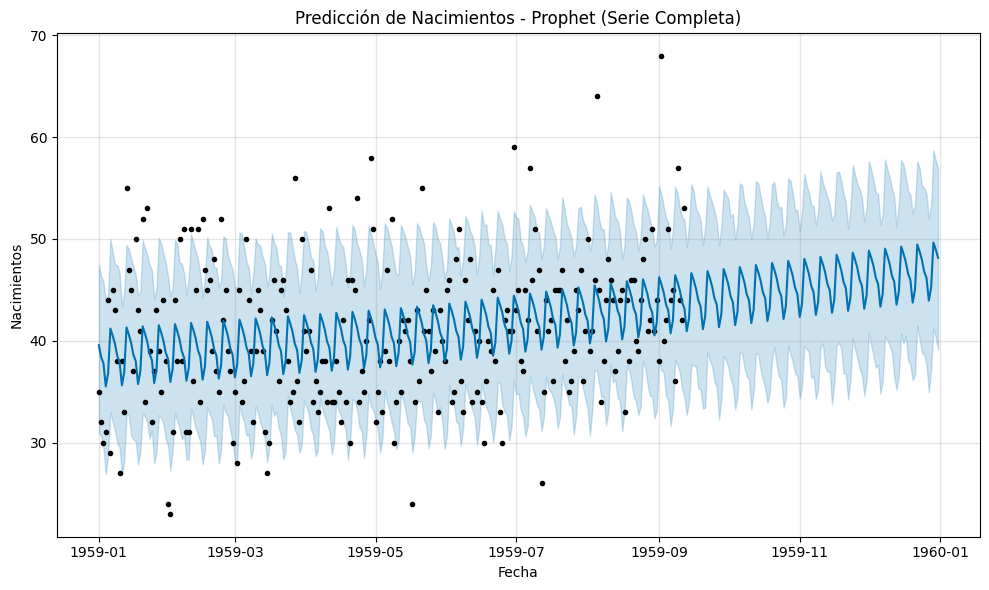

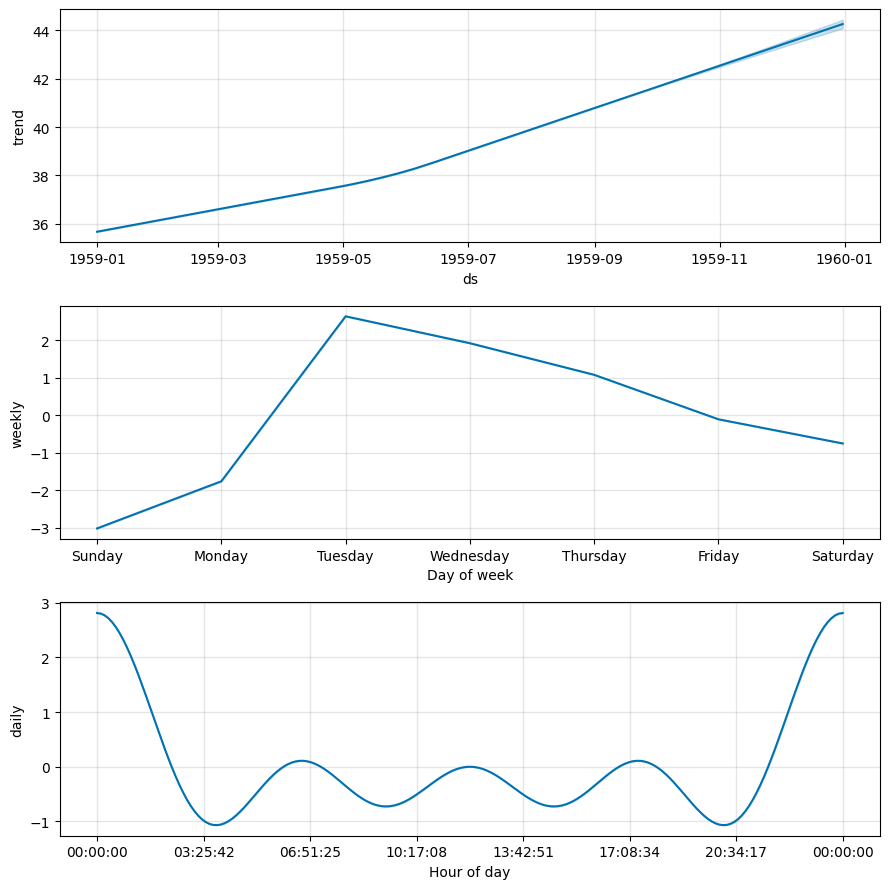

Prophet - RMSE: 7.53, MAE: 5.96


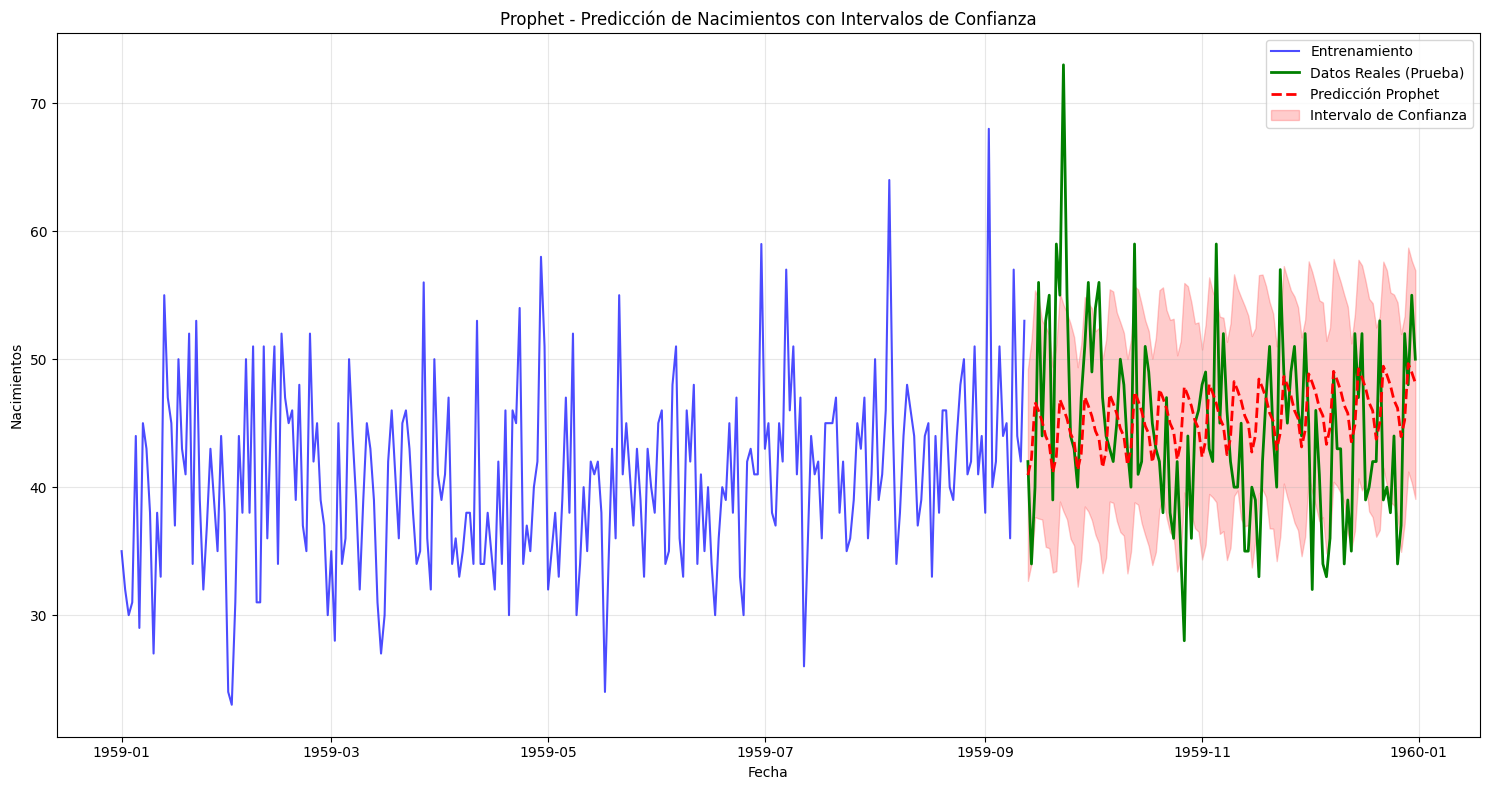

In [15]:

from prophet import Prophet

df_prophet = pd.DataFrame()
df_prophet['ds'] = train.index
df_prophet['y'] = train.values

# Crear modelo Prophet 
model_prophet = Prophet(
    daily_seasonality=True, 
    weekly_seasonality=True, 
    yearly_seasonality=False,
    seasonality_mode='additive',
    changepoint_prior_scale=0.05
)
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=len(test), freq='D')

# Hacer predicciones
forecast = model_prophet.predict(future)

# Graficar predicciones completas
fig = model_prophet.plot(forecast)
plt.title('Predicción de Nacimientos - Prophet (Serie Completa)')
plt.xlabel('Fecha')
plt.ylabel('Nacimientos')
plt.grid(True)
plt.tight_layout()
plt.show()

# Graficar componentes del modelo
fig = model_prophet.plot_components(forecast)
plt.tight_layout()
plt.show()

# Extraer predicciones para periodo de prueba
pred_test_prophet = forecast['yhat'].iloc[-len(test):].values

# Calcular métricas de rendimiento
rmse_prophet = np.sqrt(mean_squared_error(test, pred_test_prophet))
mae_prophet = mean_absolute_error(test, pred_test_prophet)

print(f"Prophet - RMSE: {rmse_prophet:.2f}, MAE: {mae_prophet:.2f}")
results_births['PROPHET_FULL'] = {
    'RMSE': rmse_prophet, 
    'MAE': mae_prophet, 
    'predictions': pred_test_prophet
}

# Visualización periodo de prueba
plt.figure(figsize=(15, 8))
plt.plot(train.index, train, label='Entrenamiento', color='blue', alpha=0.7)
plt.plot(test.index, test, label='Datos Reales (Prueba)', color='green', linewidth=2)
plt.plot(test.index, pred_test_prophet, label='Predicción Prophet', color='red', linestyle='--', linewidth=2)

#bandas de confianza
forecast_test = forecast.iloc[-len(test):]
plt.fill_between(test.index, 
                 forecast_test['yhat_lower'].values, 
                 forecast_test['yhat_upper'].values, 
                 color='red', alpha=0.2, label='Intervalo de Confianza')

plt.title("Prophet - Predicción de Nacimientos con Intervalos de Confianza")
plt.xlabel("Fecha")
plt.ylabel("Nacimientos")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Comparación Modelos 

   COMPARACIÓN DE MODELOS 
Modelo             RMSE     MAE     
----------------------------------------
Promedios Móviles  6.97     5.59    
SES                7.21     5.66    
Holt-Winters       7.40     5.80    
SARIMA             7.77     6.20    
Prophet            7.53     5.96    


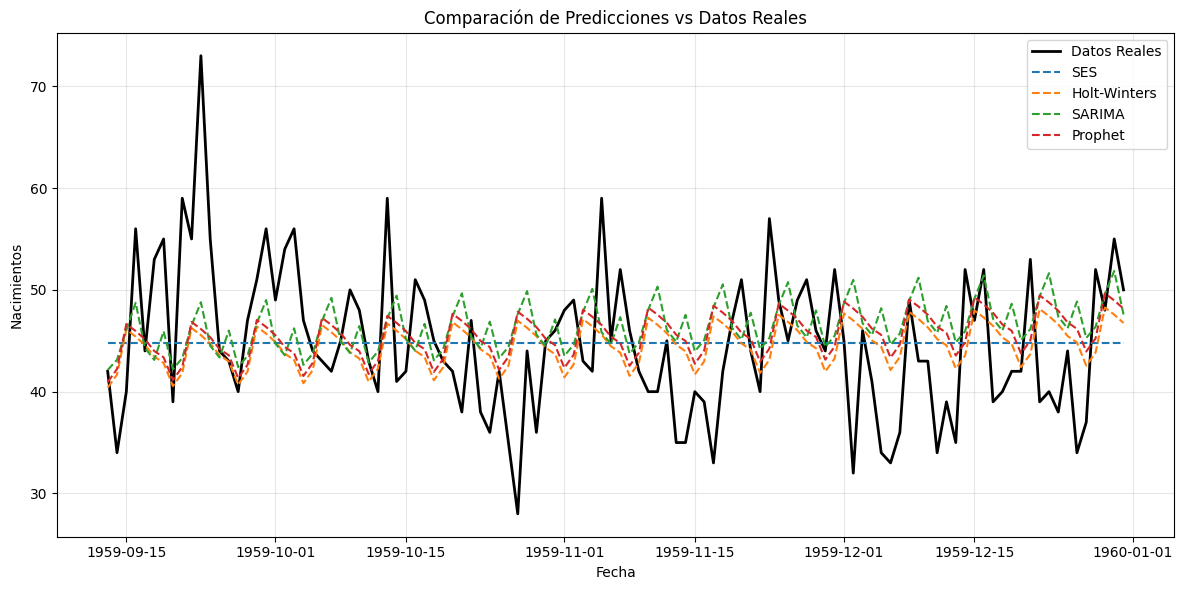

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluar(y_real, y_pred):
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mae = mean_absolute_error(y_real, y_pred)
    return rmse, mae

y_true = test

resultados = {
    'Promedios Móviles': evaluar(y_true, ma_pred),
    'SES': evaluar(y_true, modelo_ajustado.forecast(len(test))),
    'Holt-Winters': evaluar(y_true, pred_hw),
    'SARIMA': evaluar(y_true, pred_sarima),
    'Prophet': evaluar(y_true, pred_test_prophet)
}

print("=" * 40)
print("   COMPARACIÓN DE MODELOS ")
print("=" * 40)
print(f"{'Modelo':<18} {'RMSE':<8} {'MAE':<8}")
print("-" * 40)
for modelo, (rmse, mae) in resultados.items():
    print(f"{modelo:<18} {rmse:<8.2f} {mae:<8.2f}")
print("=" * 40)

# Gráfico comparativo simple
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Datos Reales', color='black', linewidth=2)
plt.plot(test.index, modelo_ajustado.forecast(len(test)), label='SES', linestyle='--')
plt.plot(test.index, pred_hw, label='Holt-Winters', linestyle='--')
plt.plot(test.index, pred_sarima, label='SARIMA', linestyle='--')
plt.plot(test.index, pred_test_prophet, label='Prophet', linestyle='--')

plt.title('Comparación de Predicciones vs Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Nacimientos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()